In [1]:
import pandas as pd
from collections import defaultdict
from scipy.stats import kruskal
import numpy as np
import statsmodels.stats.multitest as smt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
import warnings
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
from skbio.stats.distance import permanova
from skbio.stats.distance import DistanceMatrix
from matplotlib.patches import Ellipse
from scipy.stats import mannwhitneyu
import statsmodels.stats.multitest as smt
# from statannotations.Annotator import Annotator
from sklearn.metrics import pairwise_distances
from mpl_toolkits.basemap import Basemap
from collections import OrderedDict

/Users/jingqiuliao/.pyenv/versions/miniconda3-latest/envs/leaph-US_soil_microbiome_16s/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Common Functions

In [2]:
# function for FDR correction
def fdr_sig(p_value):
    """
    Performs False Discovery Rate (FDR) correction using the Benjamini-Hochberg method.

    Parameters:
        p_value (dict): Dictionary where keys are variable names and values are lists of p-values.

    Returns:
        dict: Dictionary containing variables with significant corrected p-values (p < 0.05).
    """
    p_v = []
    for c_key in p_value:
        p_v.append(p_value[c_key][0])
    array = np.array(p_v)
    rej, pvalscorr, _, _ = smt.multipletests(array, method = 'fdr_bh')
    p_corr = pvalscorr.tolist()
    n_p = 0
    sig_fdr = {}
    for c_key in p_value:
        if p_corr[n_p] < 0.05:
            sig_fdr[c_key] = p_corr[n_p]
        n_p = n_p + 1
    return sig_fdr

In [3]:
def KW_test(df):
    """
    Conducts Kruskal-Wallis tests across groups defined in 'Ecosystem_recode' and applies FDR correction.

    Parameters:
        df (DataFrame): DataFrame with columns for each variable and a 'Ecosystem_recode' column indicating groups.

    Returns:
        tuple: A dictionary of significant variables after FDR correction and a dictionary of original p-values.
    """
    columns_to_test = df.columns.drop(['Sample ID', 'Ecosystem_recode'])

    excluded_columns = []
    pval = defaultdict(list)

    for column in columns_to_test:
        # Splitting the data based on 'Ecosystem_recode'
        data_forest_woodland = df[df['Ecosystem_recode'] == 'Forest/Woodland'][column]
        data_barren = df[df['Ecosystem_recode'] == 'Barren'][column]
        data_wetland = df[df['Ecosystem_recode'] == 'Wetland'][column]
        # data_unknown = df[df['Ecosystem_recode'] == 'Unknown'][column]
        data_shrubland = df[df['Ecosystem_recode'] == 'Shrubland'][column]
        data_herbaceous = df[df['Ecosystem_recode'] == 'Herbaceous'][column]
        data_steppe = df[df['Ecosystem_recode'] == 'Steppe/Savanna'][column]

        # Check if there's variability within each ecosystem group
        if len(set(data_forest_woodland)) > 1 and len(set(data_barren)) > 1 and len(set(data_wetland)) > 1 and len(set(data_shrubland)) > 1 and len(set(data_herbaceous)) > 1 and len(set(data_steppe)) > 1 :
            # Performing the Kruskal-Wallis test
            stat, p_value = kruskal(data_forest_woodland, data_barren, data_wetland, data_shrubland, data_herbaceous, data_steppe)
            pval[column].append(p_value)
        else:
            excluded_columns.append(column)
            pval[column].append(np.float64(1.0))

    sig_env = fdr_sig(pval)
    n_sig_env = len(sig_env)
    print("Number of siginificant variables: ", n_sig_env)
    print("--------------------------------------------")
    for key, value in sig_env.items():
        print(f'{key}: {value}')
    return sig_env, pval


In [4]:
def data_cleaner(count_data, sep):
  """
    Cleans and processes taxonomic data by simplifying names based on a separator and handling unknown entries uniquely.

    Parameters:
        count_data (DataFrame): DataFrame containing taxonomic data.
        sep (str): Separator used in taxon names (e.g., 'p__', 'g__').

    Returns:
        DataFrame: DataFrame with processed and renamed taxonomic data.
    """

  def extract_new_name(col_name, sep, unknown_counter=None):
    # Splitting the string at 'p__'
    if col_name == "index":
        return col_name
    parts = col_name.split(sep)
    if len(parts) > 1:
        # Further splitting at ';' and taking the first part
        new_name = parts[1].split(';')[0]
        if len(new_name) <= 1:
            new_name = 'Unknown'
    else:
        new_name = 'Unknown'
    # Ensuring uniqueness for 'Unknown' columns
    if new_name == 'Unknown' and unknown_counter is not None:
        new_name += f"_{unknown_counter[0]}"
        unknown_counter[0] += 1
    return new_name

  # Initialize a counter for 'Unknown' names
  unknown_counter = [1]

  # Renaming the columns with a unique identifier for 'Unknown'
  new_column_names = {col: extract_new_name(col, sep, unknown_counter=unknown_counter) for col in count_data.columns}

  count_data_cleaned = count_data.rename(columns=new_column_names)

  # Identify all 'Unknown' columns
  unknown_columns = [col for col in count_data_cleaned.columns if 'Unknown' in col]

  # sum unknown columns into a new column
  if unknown_columns:
      count_data_cleaned['Unknown'] = count_data_cleaned[unknown_columns].sum(axis=1)

  count_data_cleaned = count_data_cleaned.drop(columns=unknown_columns)

  # Calculate the sum of each column
  row_sums = count_data_cleaned.iloc[:, 1:].sum(axis=1)

  # Divide each entry of each column by the respective row sum
  count_data_cleaned.iloc[:, 1:] = count_data_cleaned.iloc[:, 1:].div(row_sums, axis=0)

  count_data_cleaned.drop('Unknown', axis=1, inplace=True, errors='ignore')

  return count_data_cleaned


In [5]:
def mds_processing(custom_dist_matrix, group):
    """
    Processes a custom distance matrix for Multidimensional Scaling (MDS) and classifies samples into groups.

    Parameters:
        custom_dist_matrix (DataFrame): DataFrame containing the distance matrix.
        group (DataFrame): DataFrame with group classification for each sample.

    Returns:
        tuple: DataFrame containing MDS coordinates with group labels, and PERMANOVA test results.
    """
    # Filter rows to ensure that the group and custom dist matrix have same sample ids
    filtered_custom_dist_matrix = custom_dist_matrix[custom_dist_matrix['Unnamed: 0'].isin(group.index)]

    # Filter columns
    filtered_custom_dist_matrix = filtered_custom_dist_matrix[['Unnamed: 0'] + [col for col in filtered_custom_dist_matrix.columns if col in group.index]]

    # Compute the distance matrix
    distance_matrix = filtered_custom_dist_matrix.drop(columns=['Unnamed: 0']).to_numpy()

    # Perform MDS
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=20)
    mds_coordinates = mds.fit_transform(distance_matrix)


    # Classify samples into groups

    mds_2d_df = pd.DataFrame(mds_coordinates).set_index(filtered_custom_dist_matrix['Unnamed: 0'])
    mds_group = pd.merge(mds_2d_df, group, left_index=True, right_index=True)


    # perform permanova test on grouping
    grouping = list(mds_group['group'])

    symmetric_distance_matrix = (distance_matrix + distance_matrix.T) / 2
    symmetric_distance_matrix = DistanceMatrix(symmetric_distance_matrix, ids=filtered_custom_dist_matrix['Unnamed: 0'])

    permanova_results = permanova(symmetric_distance_matrix, grouping, permutations=999)
    print(permanova_results)


    return mds_group, permanova_results

In [6]:
#function for making ellipse
from matplotlib.patches import Ellipse

def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma ellipse based on the mean and covariance of a point
    "cloud" (points, an Nx2 array).

    Parameters
    ----------
        points : An Nx2 array of the data points.
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, linewidth=2.0, **kwargs)

    ax.add_artist(ellip)
    return ellip

In [7]:
def ecosystem_mds_plot(mds_group, permanova_results, x_lim, y_lim, plot_name, save_file_name):
    """
    Creates a scatter plot for MDS coordinates colored by ecosystem type and adds ellipses to represent group variances.

    Parameters:
        mds_group (DataFrame): DataFrame containing MDS coordinates and group labels.
        permanova_results (dict): Results from the PERMANOVA test.
        x_lim (float): Limit for the x-axis of the plot.
        y_lim (float): Limit for the y-axis of the plot.
        plot_name (str): Title for the plot.
        save_file_name (str): Path to save the plot file.

    Returns:
        None: Displays and saves the plot as specified.
    """

    colors = ['#666666', '#45B39D', '#A0522D', '#CD6155', '#AF7AC5', '#1E90FF']
    hue_order = ['Barren', 'Forest/Woodland', 'Herbaceous', 'Shrubland', 'Steppe/Savanna', 'Wetland']

    # Create the plot
    plt.rcParams["figure.figsize"] = (5, 5)
    ax = sns.scatterplot(x=0, y=1, hue='group', data=mds_group,
                        palette=colors, hue_order=hue_order, alpha = 0.8,
                        s=120, edgecolor='black')

    # Plotting ellipses
    for lineage, color in zip(hue_order, colors):
        group_data = mds_group[mds_group['group'] == lineage][[0, 1]].values
        e = plot_point_cov(group_data, ax=ax, edgecolor=color, facecolor='none')

    # Setting the plot title and labels
    ax.set_title(plot_name, size=15)
    plt.xlabel('MDS Coordinate 1', size=15)
    plt.ylabel('MDS Coordinate 2', size=15)

    # Setting the plot limits
    plt.xlim(-x_lim, x_lim)
    plt.ylim(-y_lim, y_lim)

    # Adding text for Permanova p value
    plt.text(1, 0, f'PERMANOVA P = {permanova_results["p-value"]}', fontsize=12, ha='right', va='bottom', transform=ax.transAxes)
    plt.legend(title="Ecosystems", bbox_to_anchor=(1.03, 0.4))

    plt.savefig(save_file_name, format='pdf', bbox_inches='tight', dpi=600)
    plt.tight_layout()

    # Display the plot
    plt.show()

In [8]:
def bubble_plot(df, sig_var, plot_title, pdf_file):
    """
    Creates a bubble plot of median abundances for significant bacterial groups across different ecosystems.

    Parameters:
        df (DataFrame): DataFrame containing ecosystem data and bacterial group abundances.
        sig_var (dict): Dictionary of significant variables and their corresponding corrected p-values.
        plot_title (str): Title of the plot.

    Returns:
        None: Displays the bubble plot.
    """
    sig_columns = list(sig_var.keys())

    # Excluding rows where 'Ecosystem_recode' is "unknown"
    df = df[df['Ecosystem_recode'].str.lower() != "unknown"]

    ecosystems = df['Ecosystem_recode'].unique()

    abundance_values = []
    max_abundance_values = []
    for col in sig_columns:
        for eco in ecosystems:
            median_abundance = df[df['Ecosystem_recode'] == eco][col].mean()
            max_abundance = df[df['Ecosystem_recode'] == eco][col].max()
            abundance_values.append(median_abundance)
            max_abundance_values.append(max_abundance)

    plot_df = pd.DataFrame({
        'Bacterial Group': np.repeat(sig_columns, len(ecosystems)),
        'Ecosystem': np.tile(ecosystems, len(sig_columns)),
        'Abundance': abundance_values,
        'Max Abundance': max_abundance_values
    })

    # Normalizing bubble sizes within each bacterial group
    min_size, max_size = 100, 500
    for group in plot_df['Bacterial Group'].unique():
        group_indices = plot_df['Bacterial Group'] == group
        min_abundance = plot_df.loc[group_indices, 'Abundance'].min()
        max_abundance = plot_df.loc[group_indices, 'Abundance'].max()
        plot_df.loc[group_indices, 'Bubble Size'] = (plot_df.loc[group_indices, 'Abundance'] - min_abundance) / (max_abundance - min_abundance)
        plot_df.loc[group_indices, 'Bubble Size'] = plot_df.loc[group_indices, 'Bubble Size'] * (max_size - min_size) + min_size

        # Ensure non-zero bubble size
        plot_df.loc[group_indices, 'Bubble Size'] = plot_df.loc[group_indices, 'Bubble Size'].replace(0, min_size)

    class_colors = {
        'Forest/Woodland': '#45B39D',
        'Barren': '#666666',
        'Wetland': '#1E90FF',
        'Shrubland': '#CD6155',
        'Herbaceous': '#A0522D',
        'Steppe/Savanna': '#AF7AC5'
    }

    plt.figure(figsize=(5, 7))
    for group in plot_df['Bacterial Group'].unique():
        group_df = plot_df[plot_df['Bacterial Group'] == group]
        colors = [class_colors[eco] for eco in group_df['Ecosystem']]
        plt.scatter(group_df['Ecosystem'], group_df['Bacterial Group'], s=group_df['Bubble Size'], c=colors, alpha=0.5, label=group)

    plt.xticks(fontsize=12, rotation=45, ha='right')
    plt.xlabel('')
    plt.ylabel('')
    plt.title(plot_title, size=14)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(rotation=45)
    plt.savefig('../output/' + pdf_file, format='pdf', bbox_inches='tight', dpi=600)
    plt.show()


In [9]:
def save_stats_to_csvs(df, sig_var, pval, filename_prefix):
    """
    Saves statistical summaries (mean, median, max, min) of significant variables to CSV files.

    Parameters:
        df (DataFrame): DataFrame containing the data to summarize.
        sig_var (dict): Dictionary of significant variables with their corrected p-values.
        pval (dict): Dictionary of original p-values for each variable.
        filename_prefix (str): Prefix for the CSV filenames to save the summaries.

    Returns:
        tuple: DataFrames for mean, mode, median, max, and min summaries.
    """

    sig_var = {k: v for k, v in sig_var.items() if k.lower() != "unknown"}

    # Excluding rows where 'Ecosystem_recode' is "unknown"
    df = df[df['Ecosystem_recode'].str.lower() != "unknown"]

    sig_columns = list(sig_var.keys())
    ecosystems = df['Ecosystem_recode'].unique()

    # Initializing DataFrames for each statistic
    mean_df = pd.DataFrame(index=sig_columns, columns=ecosystems)
    mode_df = pd.DataFrame(index=sig_columns, columns=ecosystems)
    median_df = pd.DataFrame(index=sig_columns, columns=ecosystems)
    max_df = pd.DataFrame(index=sig_columns, columns=ecosystems)
    min_df = pd.DataFrame(index=sig_columns, columns=ecosystems)

    for col in sig_columns:
        for eco in ecosystems:
            filtered_df = df[df['Ecosystem_recode'] == eco][col]
            mean_df.loc[col, eco] = filtered_df.mean()
            mode_df.loc[col, eco] = filtered_df.mode().tolist() # There can be multiple modes
            median_df.loc[col, eco] = filtered_df.median()
            max_df.loc[col, eco] = filtered_df.max()
            min_df.loc[col, eco] = filtered_df.min()

    # Adding adjusted p_value and p_value columns
    for stat_df in [mean_df, mode_df, median_df, max_df, min_df]:
        stat_df['adjusted_p_value'] = stat_df.index.map(sig_var)
        stat_df['p_value'] = stat_df.index.map(lambda x: pval[x][0] if x in pval and len(pval[x]) > 0 else None)

    # Saving DataFrames to CSV
    mean_df.to_csv('../output/'+ f'{filename_prefix}_mean.csv')
    # mode_df.to_csv('../output/'+ f'{filename_prefix}_mode.csv')
    median_df.to_csv('../output/'+ f'{filename_prefix}_median.csv')
    max_df.to_csv('../output/'+ f'{filename_prefix}_max.csv')
    min_df.to_csv('../output/'+ f'{filename_prefix}_min.csv')

    return mean_df, mode_df, median_df, max_df, min_df

In [10]:
def plot_heatmap_mean_log(mean_data, title="", figsize=(6, 6)):
    """
    Plots a heatmap of log-transformed mean values for the three classes (L1, L2, L3) based on significant variables.

    Parameters:
    - mean_data (DataFrame): The DataFrame containing mean values for each variable and class.
    - title (str): Title of the plot.
    - figsize (tuple): Size of the figure.
    """

    # Take the logarithm of the data
    log_mean_data = np.log(np.abs(mean_data))

    # Create the heatmap
    plt.figure(figsize=figsize)
    ax = sns.heatmap(log_mean_data, cmap='coolwarm', annot=False, linewidths=0.5)
    plt.xlabel('')
    plt.ylabel('')
    plt.title(title, size=13)
    plt.xticks(fontsize=13, rotation=45, ha='right')


    # Add a title for the color bar
    color_bar = ax.collections[0].colorbar
    color_bar.set_label('Values (log)', size=12)

    plt.savefig('../output/' + f'{title}.pdf', format='pdf', bbox_inches='tight',  dpi=600)

    plt.show()

# Ecosystem prevalence

In [11]:
ecosystem_df = pd.read_csv("../../Input/ecosystem.csv", index_col=0)
alpha_div_df = pd.read_csv("../../Input/OTU_shannon_vector.tsv", sep='\t', index_col=0)

eco_alpha_div = pd.merge(ecosystem_df, alpha_div_df, left_index = True, right_index = True)

# get count of samples for each ecosystem
eco_ct = eco_alpha_div.groupby("Ecosystem_recode").count().reset_index()
eco_ct = eco_ct.sort_values('shannon', ascending=False)
eco_ct

,Ecosystem_recode,shannon
1,Forest/Woodland,298
2,Herbaceous,134
6,Wetland,54
3,Shrubland,44
4,Steppe/Savanna,31
5,Unknown,29
0,Barren,26


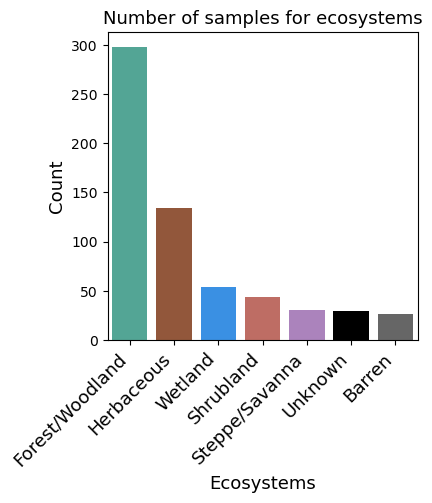

In [12]:
# plot the frequency of samples for ecosystems

group_colors = {
    'Forest/Woodland': '#45B39D',
    'Barren': '#666666',
    'Wetland': '#1E90FF',
    'Shrubland': '#CD6155',
    'Herbaceous': '#A0522D',
    'Steppe/Savanna': '#AF7AC5',
    'Unknown': 'black'
}

plt.rcParams["figure.figsize"] = (4, 4)

ax = sns.barplot(data = eco_ct, x="Ecosystem_recode", y="shannon", hue="Ecosystem_recode", palette=group_colors, dodge=False)
ax.set_xlabel('Ecosystems', size=13)
ax.set_ylabel('Count', size=13)
ax.set_title('Number of samples for ecosystems', size=13)
plt.xticks(fontsize=13, rotation=45, ha='right')
plt.savefig('../output/ecosystem_prevalence.pdf', bbox_inches='tight', dpi=600)
plt.show()

# Abiotic environmental conditions compared among ecosystems

In [18]:
df_enviro = pd.read_csv("../../Input/environ_all.csv")
df_enviro = df_enviro.dropna()

### Abiotic environmental variables associated with ecosystems (KW test)

In [19]:
env_with_eco = pd.merge(df_enviro, ecosystem_df, on='Sample ID')
ecosystem_df = pd.read_csv("../../Input/ecosystem.csv")
ecosystem_df = ecosystem_df[ecosystem_df['Ecosystem_recode'].str.lower() != "unknown"]

#sig var
sig_var, _ = KW_test(env_with_eco)

Number of siginificant variables:  30
--------------------------------------------
Latitude: 5.21494251389595e-29
Longitude: 2.2926434676636346e-24
Elevation (m): 7.922952608187436e-16
Moisture: 2.7738560666576297e-17
Total nitrogen (%): 2.5413278794841138e-05
Total carbon (%): 1.136106776757474e-05
pH: 1.0737281602736096e-22
Organic matter (%): 1.5663864867812602e-11
Aluminum (mg/Kg): 9.589289257139776e-19
Calcium (mg/Kg): 2.375340836693503e-09
Copper (mg/Kg): 4.26870805041017e-06
Iron (mg/Kg): 3.7260081607902676e-26
Potassium (mg/Kg): 9.872592425469048e-18
Magnesium (mg/Kg): 5.890674758806728e-15
Manganese (mg/Kg): 1.8272544916913588e-14
Phosphorus (mg/Kg): 4.09126357494641e-06
Zinc (mg/Kg): 1.7397382188066688e-17
Precipitation (mm): 3.334486119200293e-38
Max temperature (C): 2.524698184012563e-33
Min temperature (C): 4.150960845872564e-33
Wind speed (m/s): 6.94526409086813e-20
Open water (%): 2.048856288113805e-08
Developed (< 20% Impervious) (%): 4.296727006074718e-09
Developed (> 

In [20]:
unique_eco =  list(ecosystem_df["Ecosystem_recode"].unique())

heatmap_df = pd.DataFrame(columns=unique_eco)

for key, val in sig_var.items():
    prep_gp = pd.merge(df_enviro, ecosystem_df, on='Sample ID')
    prep_gp = prep_gp[[f"{key}", 'Ecosystem_recode']]
    # Calculate mean values for positive and negative groups
    mean_forest = prep_gp[prep_gp['Ecosystem_recode'] == 'Forest/Woodland'][key].mean()
    mean_barren = prep_gp[prep_gp['Ecosystem_recode'] == 'Barren'][key].mean()
    mean_wetland = prep_gp[prep_gp['Ecosystem_recode'] == 'Wetland'][key].mean()
    mean_shrubland = prep_gp[prep_gp['Ecosystem_recode'] == 'Shrubland'][key].mean()
    mean_herbaceous = prep_gp[prep_gp['Ecosystem_recode'] == 'Herbaceous'][key].mean()
    mean_steppe_savanna = prep_gp[prep_gp['Ecosystem_recode'] == 'Steppe/Savanna'][key].mean()

    # Append the results to the heatmap_df DataFrame
    heatmap_df.loc[key] = [mean_forest, mean_barren, mean_wetland, mean_shrubland, mean_herbaceous, mean_steppe_savanna]


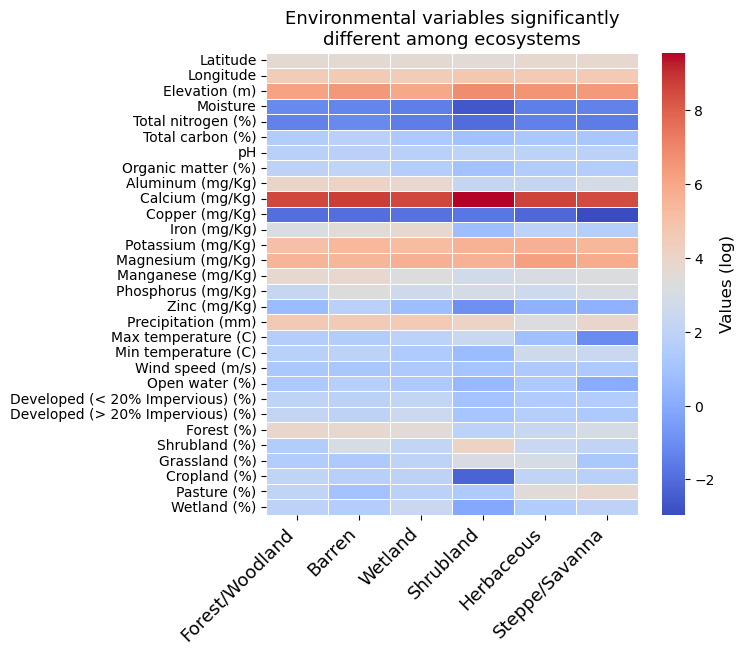

In [21]:
plot_heatmap_mean_log(heatmap_df, "Environmental variables significantly\ndifferent among ecosystems")

### Dissimilarity of abiotic environmental conditions (MDS)

In [22]:
ecosystem_df = ecosystem_df.set_index('Sample ID')
df_enviro = df_enviro.set_index('Sample ID')

sample = df_enviro.copy()
merged_df = pd.merge(sample, ecosystem_df, left_index=True, right_index=True)

group = merged_df[['Ecosystem_recode']]
group.rename(columns={'Ecosystem_recode': 'group'}, inplace=True)

/var/folders/5h/7h8l0j1s1mj4_v25_lxmx1lw0000gn/T/ipykernel_33259/3523228248.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group.rename(columns={'Ecosystem_recode': 'group'}, inplace=True)


In [23]:
# use significant environmental variables as input for MDS
sig_env_df= df_enviro[df_enviro.columns.intersection(list(sig_var.keys()))]
sig_env_df = pd.merge(sig_env_df, group, left_index=True, right_index=True)
sig_env_df = sig_env_df.drop("group", axis=1)

In [24]:
# Make an MDS plot using Euclidean distance

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(sig_env_df)

# Compute the distance matrix
distance_matrix = pairwise_distances(scaled_data, metric='euclidean')

# Perform MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=20)
mds_coordinates = mds.fit_transform(distance_matrix)

In [25]:
# Classify samples into groups based on presence of Ecosystem classes

mds_2d_df = pd.DataFrame(mds_coordinates).set_index(sig_env_df.index)
mds_group = pd.merge(mds_2d_df, group, left_index=True, right_index=True)

In [26]:
# perform permanova test on grouping

grouping = list(mds_group['group'])

symmetric_distance_matrix = (distance_matrix + distance_matrix.T) / 2
symmetric_distance_matrix = DistanceMatrix(symmetric_distance_matrix, ids=sig_env_df.index)

permanova_results = permanova(symmetric_distance_matrix, grouping, permutations=999)
print(permanova_results)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     561
number of groups                  6
test statistic            17.047692
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object


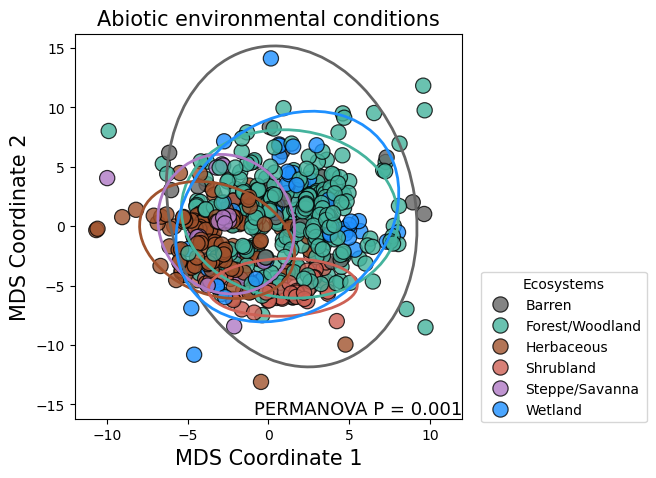

In [27]:
colors = ['#666666', '#45B39D', '#A0522D', '#CD6155', '#AF7AC5', '#1E90FF']
hue_order = ['Barren', 'Forest/Woodland', 'Herbaceous', 'Shrubland', 'Steppe/Savanna', 'Wetland']

# Create the plot
plt.rcParams["figure.figsize"] = (5, 5)
ax = sns.scatterplot(x=0, y=1, hue='group', data=mds_group,
                     palette=colors, hue_order=hue_order, alpha = 0.8,
                     s=120, edgecolor='black')

# Plotting ellipses
for lineage, color in zip(hue_order, colors):
    group_data = mds_group[mds_group['group'] == lineage][[0, 1]].values
    e = plot_point_cov(group_data, ax=ax, edgecolor=color, facecolor='none')

# Setting the plot title and labels
ax.set_title('Abiotic environmental conditions', size=15)
plt.xlabel('MDS Coordinate 1', size=15)
plt.ylabel('MDS Coordinate 2', size=15)

# Setting the plot limits
plt.xlim(-12, 12)
plt.ylim(-16.2, 16.2)

# Adding text for Permanova p value
plt.text(1, 0, f'PERMANOVA P = {permanova_results["p-value"]}', fontsize=13, ha='right', va='bottom', transform=ax.transAxes)
plt.legend(title="Ecosystems", bbox_to_anchor=(1.03, 0.4))
plt.savefig('../output/abiotic_env_MDS_ecosystems.pdf', format='pdf', bbox_inches='tight', dpi=600)
# Display the plot
plt.show()

# Shannon diversity compared across ecosystems

### Map of Shannon diversity across the US

In [28]:
def plot_by_location(lats, lons, shannon_indices, classes, plot_title, min_index, max_index):
    class_colors = {
        'Forest/Woodland': '#45B39D',
        'Barren': '#666666',
        'Wetland': '#1E90FF',
        'Shrubland': '#CD6155',
        'Herbaceous': '#A0522D',
        'Steppe/Savanna': '#AF7AC5',
        'Unknown': 'black'
    }

    lat_min, lat_max = np.min(lats) - 1, np.max(lats) + 1
    lon_min, lon_max = np.min(lons) - 1, np.max(lons) + 1

    plt.figure(figsize=(12, 6))
    map = Basemap(projection='merc', llcrnrlat=lat_min, urcrnrlat=lat_max, llcrnrlon=lon_min, urcrnrlon=lon_max, resolution='i')

    # Set the background color of the map )
    map.drawcountries(linewidth=0.5, color='black')
    map.fillcontinents(color='#F8F9F9', lake_color='lightblue')

    # Adjusting the axis labels
    map.drawparallels(np.arange(25,55,5),color='lightgray', labels=[1,0,0,0])
    map.drawmeridians(np.arange(-125,-65,5),color='lightgray', labels=[0,0,0,1],rotation=45)
    map.drawmapboundary(fill_color='lightblue')

    # max_marker_size = 200
    for lat, lon, shannon_index, class_type in zip(lats, lons, shannon_indices, classes):
        x, y = map(lon, lat)
        msize = (shannon_index - min_index) * (200)/(max_index-min_index) + 50
        map.scatter(x, y, s=msize, c=class_colors.get(class_type, 'black'), edgecolors='#212121', linewidth=0.9, label=class_type, alpha=0.4, zorder = 2)


    # To handle legend duplicates and include all class types
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='lower right', title="Classes")
    plt.title(plot_title, size=16)
    plt.savefig('../output/diversity_ecosystems_map.pdf', format='pdf', dpi=600)
    plt.show()

In [29]:
df_enviro = pd.read_csv("../../Input/environ_all.csv")
shannon_data = pd.read_csv("../../Input/OTU_shannon_vector.tsv", sep='\t')
ecosystem_df = pd.read_csv("../../Input/ecosystem.csv")

shannon_data.rename(columns={"Unnamed: 0" : "Sample ID"}, inplace=True)

In [30]:
megerd_df = pd.merge(df_enviro, shannon_data, on='Sample ID')
megered_with_eco = pd.merge(megerd_df, ecosystem_df, on='Sample ID')

In [31]:
# Extract latitude, longitude, Shannon index, and class column
lats = megered_with_eco['Latitude'].values
lons = megered_with_eco['Longitude'].values
indices = megered_with_eco['shannon'].values
classes = megered_with_eco['Ecosystem_recode'].values

plot_title = "Soil microbial diversity of ecosystems across the US"

min_index = indices.min()
max_index = indices.max()

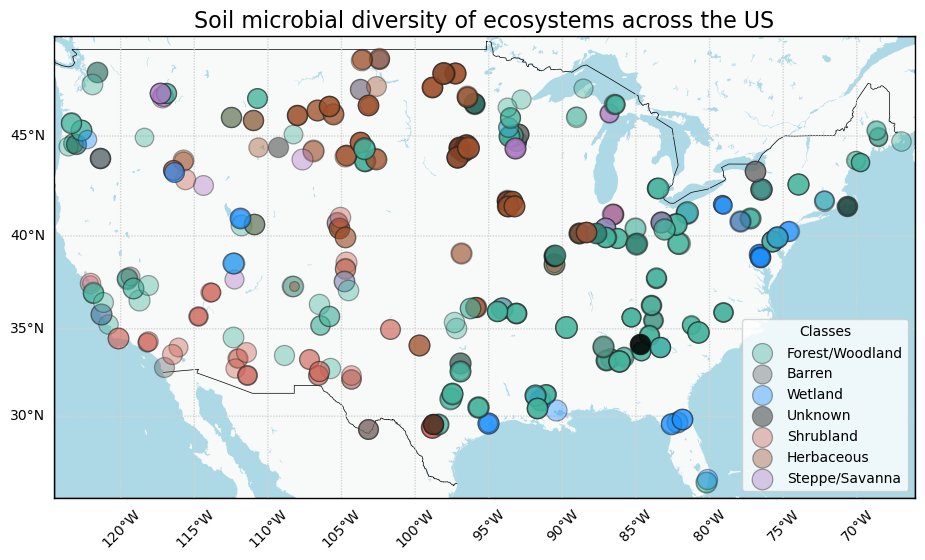

In [32]:
plot_by_location(lats, lons, indices, classes, plot_title, min_index, max_index)

### Ridge Plot

In [33]:
shannon_vector_df = pd.read_csv("../../Input/OTU_shannon_vector.tsv", sep='\t')
shannon_vector_df.rename(columns={"Unnamed: 0" : "Sample ID"}, inplace=True)

ecosystem_df = pd.read_csv("../../Input/ecosystem.csv")
ecosystem_df = ecosystem_df[ecosystem_df['Ecosystem_recode'].str.lower() != "unknown"]

merged_df = pd.merge(shannon_vector_df, ecosystem_df, on='Sample ID')

In [34]:
# KW test

sig_var, pval = KW_test(merged_df)
print( "FDR adjusted p_val: ", sig_var, "p_val: ", pval)

Number of siginificant variables:  1
--------------------------------------------
shannon: 0.008570199653233652
FDR adjusted p_val:  {'shannon': 0.008570199653233652} p_val:  defaultdict(<class 'list'>, {'shannon': [0.008570199653233652]})


In [35]:

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

def plot_ecosystem_shannon_distributions_median(df, kw_pval, plot_name):
    """
    Plot a FacetGrid of Shannon distributions for different ecosystems.

    Args:
    df: A pandas DataFrame with columns 'Ecosystem_recode' and 'shannon'.

    Returns:
    A seaborn FacetGrid object visualizing the distributions.
    """

    medians = df.groupby('Ecosystem_recode')['shannon'].median()
    sorted_ecosystems_by_median = medians.sort_values().index.tolist()

    class_colors = {
        'Forest/Woodland': '#45B39D',
        'Barren': '#666666',
        'Wetland': '#1E90FF',
        'Shrubland': '#CD6155',
        'Herbaceous': '#A0522D',
        'Steppe/Savanna': '#AF7AC5'
    }

    plt.figure(figsize=(6, 6))

    g = sns.FacetGrid(df, row="Ecosystem_recode", hue="Ecosystem_recode", aspect=6,
                      height=0.9, palette=class_colors, row_order=sorted_ecosystems_by_median)
    g.map(sns.kdeplot, "shannon", clip_on=False, shade=True, alpha=0.7, lw=1,
          bw_method=0.2, edgecolor="black")

    def label(x, color, label):
        ax = plt.gca()
        ax.text(0.05, .2, label, fontweight="bold", color=color, ha="left",
                va="center", transform=ax.transAxes, fontsize=10)

    g.map(label, "shannon")
    g.fig.subplots_adjust(hspace=-0.750)
    g.set_titles("")
    g.set(yticks=[])
    g.set_ylabels('')
    g.despine(left=True)

    for i, ax in enumerate(g.axes.ravel()):
        ax.set_facecolor('none')
        ax.set_xlim(2, df['shannon'].max())
        ax.set_ylim(-0.02, ax.get_ylim()[1])

        for spine in ax.spines.values():
            spine.set_visible(spine.spine_type == 'left')

        if i == len(g.axes) - 1:  # Last subplot adjustments
            ax.spines['bottom'].set_visible(True)
            ax.spines['bottom'].set_color('black')  # Set the x-axis color if needed
            ax.tick_params(axis='x', which='both', length=0, labelbottom=True)
            ticks = np.linspace(int(df['shannon'].min()), int(df['shannon'].max()), num=5)
            ax.set_xticks(ticks)  # Set x-tick positions
            ax.set_xticklabels([f"{tick:.1f}" for tick in ticks])  # Set x-tick labels
            ax.set_xlabel("Shannon-Wiener index", fontsize=14)
        else:
            ax.tick_params(axis='x', which='both', length=0, labelbottom=False)


    plt.gcf().subplots_adjust(bottom=0.2)
    plt.text(0.15, 0.9, f"Kruskal-Wallis P = {kw_pval:.4f}", transform=plt.gcf().transFigure, fontsize=12, va='top', ha='left')
    plt.text(0.23, 1.0, 'Distribution of microbial diversity', transform=plt.gcf().transFigure, fontsize=15, va='top', ha='left')
    plt.savefig('../output/' + plot_name, format='pdf', dpi=600)
    plt.show()

<Figure size 600x600 with 0 Axes>

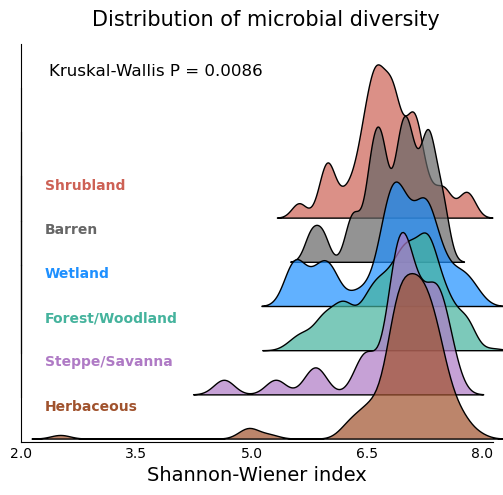

In [36]:
#order by median

plot_ecosystem_shannon_distributions_median(merged_df, sig_var["shannon"], "diversity_ecosystems_ridge_plot_median.pdf")


In [37]:
def find_distribution_peak(values):
    """
    Find the x-value of the highest peak in the histogram of given values.

    Args:
    values: A NumPy array or a pandas Series of numerical values.

    Returns:
    The x-value of the histogram peak.
    """
    counts, bin_edges = np.histogram(values, bins='auto')
    peak_index = np.argmax(counts)
    peak_x_value = (bin_edges[peak_index] + bin_edges[peak_index + 1]) / 2
    return peak_x_value

In [38]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

def plot_ecosystem_shannon_distributions_by_peak(df, kw_pval, plot_name):
    """
    Plot a FacetGrid of Shannon distributions for different ecosystems.

    Args:
    df: A pandas DataFrame with columns 'Ecosystem_recode' and 'shannon'.

    Returns:
    A seaborn FacetGrid object visualizing the distributions.
    """

    peaks = df.groupby('Ecosystem_recode')['shannon'].apply(find_distribution_peak)

    # Sort the ecosystem codes by their mode values
    sorted_ecosystems_by_peak = peaks.sort_values(ascending=True).index.tolist()

    class_colors = {
        'Forest/Woodland': '#45B39D',
        'Barren': '#666666',
        'Wetland': '#1E90FF',
        'Shrubland': '#CD6155',
        'Herbaceous': '#A0522D',
        'Steppe/Savanna': '#AF7AC5'
    }

    g = sns.FacetGrid(df, row="Ecosystem_recode", hue="Ecosystem_recode", aspect=6,
                      height=0.9, palette=class_colors, row_order=sorted_ecosystems_by_peak)
    g.map(sns.kdeplot, "shannon", clip_on=False, shade=True, alpha=0.7, lw=1,
          bw_method=0.2, edgecolor="black")

    def label(x, color, label):
        ax = plt.gca()
        ax.text(0.05, .2, label, fontweight="bold", color=color, ha="left",
                va="center", transform=ax.transAxes, fontsize=10)

    g.map(label, "shannon")
    g.fig.subplots_adjust(hspace=-0.750)
    g.set_titles("")
    g.set(yticks=[])
    g.set_ylabels('')
    g.despine(left=True)

    for i, ax in enumerate(g.axes.ravel()):
        ax.set_facecolor('none')
        ax.set_xlim(2, df['shannon'].max())
        ax.set_ylim(-0.02, ax.get_ylim()[1])

        for spine in ax.spines.values():
            spine.set_visible(spine.spine_type == 'left')

        if i == len(g.axes) - 1:  # Last subplot adjustments
            ax.spines['bottom'].set_visible(True)
            ax.spines['bottom'].set_color('black')  # Set the x-axis color if needed
            ax.tick_params(axis='x', which='both', length=0, labelbottom=True)
            ticks = np.linspace(int(df['shannon'].min()), int(df['shannon'].max()), num=5)
            ax.set_xticks(ticks)  # Set x-tick positions
            ax.set_xticklabels([f"{tick:.1f}" for tick in ticks])  # Set x-tick labels
            ax.set_xlabel("Shannon diversity index", fontsize=12)
        else:
            ax.tick_params(axis='x', which='both', length=0, labelbottom=False)

    plt.gcf().subplots_adjust(bottom=0.2)
    plt.text(0.15, 0.9, f"Kruskal-Wallis P = {kw_pval:.4f}", transform=plt.gcf().transFigure, fontsize=12, va='top', ha='left')
    plt.text(0.23, 1.0, 'Distribution of microbial diversity', transform=plt.gcf().transFigure, fontsize=15, va='top', ha='left')
    plt.savefig('../output/' + plot_name, format='pdf', dpi=600)
    plt.show()

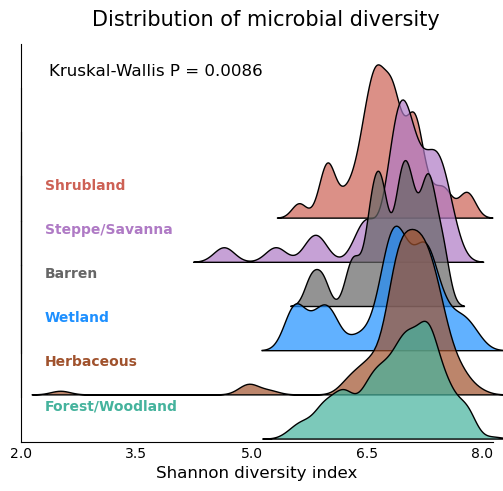

In [39]:
# order by peak
plot_ecosystem_shannon_distributions_by_peak(merged_df, sig_var["shannon"], "diversity_ecosystems_ridge_plot_peak.pdf")

# Beta diversity clustering (MDS)

Use weighted unifrac distance

In [40]:
ecosystem_df_with_index = ecosystem_df.set_index("Sample ID")
group = ecosystem_df_with_index[['Ecosystem_recode']]
group.rename(columns={'Ecosystem_recode': 'group'}, inplace=True)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     587
number of groups                  6
test statistic            22.133902
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object


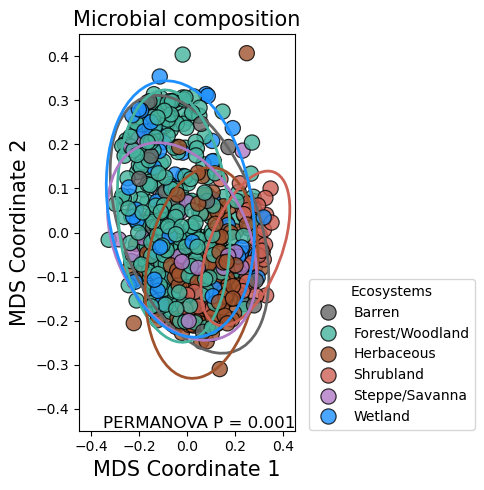

In [41]:
dis_matrix = pd.read_csv("../../Input/OTU_weighted_unifrac_distance_matrix.tsv", sep="\t")
mds_group, permanova_results = mds_processing(dis_matrix, group)
ecosystem_mds_plot(mds_group, permanova_results, x_lim = 0.45, y_lim = 0.45,
                   plot_name='Microbial composition',
                   save_file_name='../output/MDS_WeightedUnifrac_ecosystem.pdf')

# Microbial taxa associated with ecosystems

In [12]:
ecosystem_df = pd.read_csv("../../Input/ecosystem.csv")
ecosystem_df = ecosystem_df[ecosystem_df['Ecosystem_recode'].str.lower() != "unknown"]

### Phylum

In [13]:
data = data_cleaner(pd.read_csv("../../Input/phylum_count.csv"), "p__")
data.rename(columns={"index" : "Sample ID"}, inplace=True)

#merging with Ecosys data
taxa_ecosys_df = pd.merge(data, ecosystem_df, on='Sample ID')

#sig var
sig_var, _ = KW_test(taxa_ecosys_df)

Number of siginificant variables:  18
--------------------------------------------
AD3: 2.4521373336477143e-10
Acidobacteria: 4.4537355015239904e-08
Actinobacteria: 3.741963143570937e-33
Armatimonadetes: 3.3372050425032262e-12
BRC1: 0.00018923534151510916
Bacteroidetes: 0.00020330103849489997
Chloroflexi: 2.064823086487484e-18
Elusimicrobia: 0.001222122782979118
FBP: 4.2310717159547287e-26
Firmicutes: 0.009351842210583371
Gemmatimonadetes: 5.358043083118031e-20
Nitrospirae: 0.0014291131319631482
Planctomycetes: 3.085550669523704e-11
Proteobacteria: 1.1905995743386275e-29
TM6: 0.0001092516541739479
Verrucomicrobia: 3.511675807480332e-23
WPS-2: 2.895775055173213e-14
WS3: 0.000268366993592093


/var/folders/5h/7h8l0j1s1mj4_v25_lxmx1lw0000gn/T/ipykernel_34653/4041562419.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      0.002682
1      0.000206
2      0.000000
3      0.000000
4      0.003716
         ...   
613    0.000000
614    0.000000
615    0.000000
616    0.000000
617    0.012936
Name: AD3, Length: 618, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  count_data_cleaned.iloc[:, 1:] = count_data_cleaned.iloc[:, 1:].div(row_sums, axis=0)
/var/folders/5h/7h8l0j1s1mj4_v25_lxmx1lw0000gn/T/ipykernel_34653/4041562419.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      0.163985
1      0.172378
2      0.274741
3      0.266667
4      0.186829
         ...   
613    0.228272
614    0.224379
615    0.174624
616    0.205500
617    0.200918
Name: Acidobacteria, Length: 61

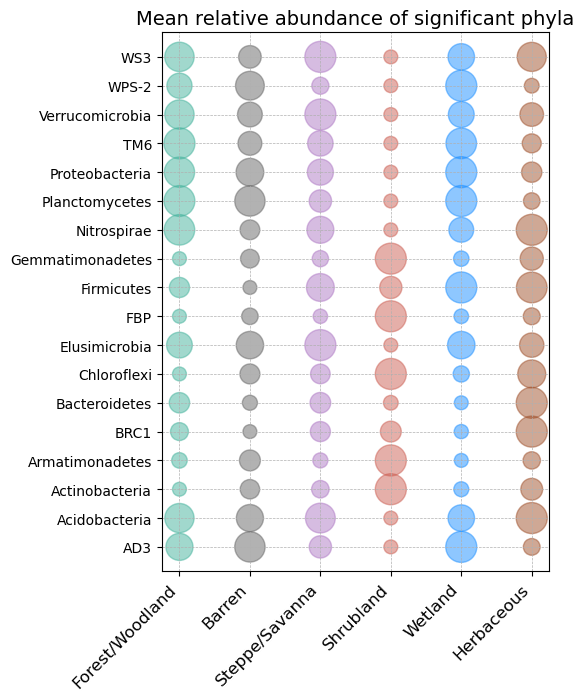

In [14]:
bubble_plot(taxa_ecosys_df, sig_var, 'Mean relative abundance of significant phyla', 'sig_phyla_ecosystems.pdf')

# Note: Bubble sizes are normalized within each bacterial group.

### Genus

In [15]:
data = data_cleaner(pd.read_csv("../../Input/genus_count.csv"), "g__")
data.rename(columns={"index" : "Sample ID"}, inplace=True)

#merging with Ecosys data
taxa_ecosys_df = pd.merge(data, ecosystem_df, on='Sample ID')

#sig var
sig_var, pval = KW_test(taxa_ecosys_df)

/var/folders/5h/7h8l0j1s1mj4_v25_lxmx1lw0000gn/T/ipykernel_34653/4041562419.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
613    0.0
614    0.0
615    0.0
616    0.0
617    0.0
Name: Acidicapsa, Length: 618, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  count_data_cleaned.iloc[:, 1:] = count_data_cleaned.iloc[:, 1:].div(row_sums, axis=0)
/var/folders/5h/7h8l0j1s1mj4_v25_lxmx1lw0000gn/T/ipykernel_34653/4041562419.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      0.004950
1      0.003303
2      0.006503
3      0.000000
4      0.000000
         ...   
613    0.000000
614    0.000000
615    0.000000
616    0.000000
617    0.000000
Name: Edaphobacter, Length: 618, dtype: float64' has dtype incompatible with in

Number of siginificant variables:  76
--------------------------------------------
Candidatus Koribacter: 1.36773687348069e-16
Candidatus Solibacter: 5.0402512812407605e-08
Iamia: 9.180984074076716e-06
Cellulomonas: 8.31299196581083e-07
Geodermatophilus: 5.211689400466277e-31
Modestobacter: 4.3199077431410905e-24
Kineococcus: 1.063235501692992e-05
Agromyces: 8.777104502949287e-12
Salinibacterium: 0.000502829879232788
Arthrobacter: 2.011237972297216e-05
Catellatospora: 0.001349574913249166
Couchioplanes: 8.398445181491293e-20
Micromonospora: 1.1193150777167874e-10
Pilimelia: 0.004816848792814146
Virgisporangium: 4.880919374035777e-05
Mycobacterium: 1.3094907161067874e-32
Nocardia: 0.004816848792814146
Aeromicrobium: 2.033873597560839e-10
Kribbella: 0.00014070292299353778
Nocardioides: 0.005611099482015907
Actinomycetospora: 1.160309002917753e-09
Amycolatopsis: 0.015459366407981035
Pseudonocardia: 4.0711727308275774e-25
Sporichthya: 2.7370447359336997e-12
Actinoallomurus: 7.3950750068585

In [16]:
mean_df, mode_df, median_df, max_df, min_df = save_stats_to_csvs(taxa_ecosys_df, sig_var, pval, "sig_genus_ecosystem")

### Class

In [17]:
data = data_cleaner(pd.read_csv("../../Input/class_count.csv"), "c__")
data.rename(columns={"index" : "Sample ID"}, inplace=True)

#merging with Ecosys data
taxa_ecosys_df = pd.merge(data, ecosystem_df, on='Sample ID')

#sig var
sig_var, pval = KW_test(taxa_ecosys_df)

/var/folders/5h/7h8l0j1s1mj4_v25_lxmx1lw0000gn/T/ipykernel_34653/4041562419.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      0.002682
1      0.000206
2      0.000000
3      0.000000
4      0.003097
         ...   
613    0.000000
614    0.000000
615    0.000000
616    0.000000
617    0.005842
Name: ABS-6, Length: 618, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  count_data_cleaned.iloc[:, 1:] = count_data_cleaned.iloc[:, 1:].div(row_sums, axis=0)
/var/folders/5h/7h8l0j1s1mj4_v25_lxmx1lw0000gn/T/ipykernel_34653/4041562419.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000619
         ...   
613    0.000000
614    0.000000
615    0.000000
616    0.000000
617    0.007094
Name: JG37-AG-4, Length: 618,

Number of siginificant variables:  53
--------------------------------------------
ABS-6: 3.2346588883490187e-06
Acidobacteria-5: 4.567308853334963e-08
Acidobacteria-6: 8.057253193162159e-10
Acidobacteriia: 1.0193917096024757e-23
DA052: 3.9693155131733093e-23
PAUC37f: 0.0003734520242986221
S035: 0.010644639559458415
Solibacteres: 1.6682380798751956e-09
[Chloracidobacteria]: 2.9294859875721624e-15
Actinobacteria: 1.0048239833712409e-12
MB-A2-108: 1.439204962600529e-23
Nitriliruptoria: 7.782603707495976e-10
Rubrobacteria: 4.006722625098948e-33
Thermoleophilia: 2.2191924057713837e-15
0319-6E2: 8.73226233474302e-09
Armatimonadia: 5.4970509017991345e-21
Chthonomonadetes: 0.0029951113177785517
PRR-11: 0.00019273895942850677
Cytophagia: 1.505980876593162e-13
Flavobacteriia: 0.00019273895942850677
Sphingobacteriia: 5.70288777389743e-08
[Saprospirae]: 0.0012165887170763523
Anaerolineae: 0.019555772490795147
C0119: 1.037616543932239e-11
Chloroflexi: 1.206391161213105e-17
Ellin6529: 2.11127519494

In [18]:
mean_df, mode_df, median_df, max_df, min_df = save_stats_to_csvs(taxa_ecosys_df, sig_var, pval, "sig_class_ecosystem")

### Order

In [19]:
data = data_cleaner(pd.read_csv("../../Input/order_count.csv"), "o__")
data.rename(columns={"index" : "Sample ID"}, inplace=True)

#merging with Ecosys data
taxa_ecosys_df = pd.merge(data, ecosystem_df, on='Sample ID')

#sig var
sig_var, pval = KW_test(taxa_ecosys_df)

/var/folders/5h/7h8l0j1s1mj4_v25_lxmx1lw0000gn/T/ipykernel_34653/4041562419.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
613    0.0
614    0.0
615    0.0
616    0.0
617    0.0
Name: BPC015, Length: 618, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  count_data_cleaned.iloc[:, 1:] = count_data_cleaned.iloc[:, 1:].div(row_sums, axis=0)
/var/folders/5h/7h8l0j1s1mj4_v25_lxmx1lw0000gn/T/ipykernel_34653/4041562419.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      0.002063
1      0.002477
2      0.008535
3      0.008889
4      0.000000
         ...   
613    0.003044
614    0.001713
615    0.001878
616    0.004000
617    0.000000
Name: CCU21, Length: 618, dtype: float64' has dtype incompatible with int64, please

Number of siginificant variables:  73
--------------------------------------------
CCU21: 1.5875881077346017e-07
iii1-15: 8.490373612225178e-10
Acidobacteriales: 8.074956800783656e-24
Ellin6513: 3.430072445500122e-23
Solibacterales: 2.229979764776991e-09
DS-100: 2.3896227528033648e-05
RB41: 6.410576200233649e-18
32-20: 2.0601018011518222e-09
DS-18: 6.99528624736889e-07
Actinomycetales: 5.181623184571497e-10
Micrococcales: 2.854498634834785e-29
0319-7L14: 1.0569080335419378e-23
Euzebyales: 1.0629088752004387e-09
Rubrobacterales: 6.34772910268485e-33
Gaiellales: 8.490373612225178e-10
Solirubrobacterales: 1.9786356739430724e-13
Armatimonadales: 6.171462229634921e-25
Chthonomonadales: 0.002227147383104403
Cytophagales: 2.6509775730291617e-13
Flavobacteriales: 0.00023184018403166827
Sphingobacteriales: 7.413261203061135e-08
[Saprospirales]: 0.001407311292840596
A31: 0.000766966915284641
Caldilineales: 0.009287768402964202
AKIW781: 4.2945175223077944e-29
Chloroflexales: 2.6947305131296547e-0

In [20]:
mean_df, mode_df, median_df, max_df, min_df = save_stats_to_csvs(taxa_ecosys_df, sig_var, pval, "sig_order_ecosystem")

### Species

In [21]:
data = data_cleaner(pd.read_csv("../../Input/species_count.csv"), "s__")
data.rename(columns={"index" : "Sample ID"}, inplace=True)

#merging with Ecosys data
taxa_ecosys_df = pd.merge(data, ecosystem_df, on='Sample ID')

#sig var
sig_var, _ = KW_test(taxa_ecosys_df)

/var/folders/5h/7h8l0j1s1mj4_v25_lxmx1lw0000gn/T/ipykernel_34653/4041562419.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
613    0.000000
614    0.000000
615    0.000000
616    0.000000
617    0.001043
Name: mallensis, Length: 618, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  count_data_cleaned.iloc[:, 1:] = count_data_cleaned.iloc[:, 1:].div(row_sums, axis=0)
/var/folders/5h/7h8l0j1s1mj4_v25_lxmx1lw0000gn/T/ipykernel_34653/4041562419.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
613    0.000000
614    0.000000
615    0.000000
616    0.000000
617    0.001252
Name: paludicola, Length:

Number of siginificant variables:  15
--------------------------------------------
obscurus: 9.93618347760577e-37
ochraceum: 7.23217762919453e-05
celatum: 7.813481701356792e-27
dilutus: 0.007212347058259133
halotolerans: 0.004330350539888554
pyridinolyticus: 5.739870524796196e-06
halophobica: 1.8078299831246823e-29
mirabilis: 7.881271204964085e-05
succinicans: 0.044345505706752886
longiquaesitum: 3.5947291311014388e-12
sullae: 1.5536028902008878e-06
massiliensis: 1.0126991996931774e-13
bryophila: 2.7112877390506984e-23
fasciculatus: 2.949743349914084e-07
umsongensis: 6.955087828939424e-06


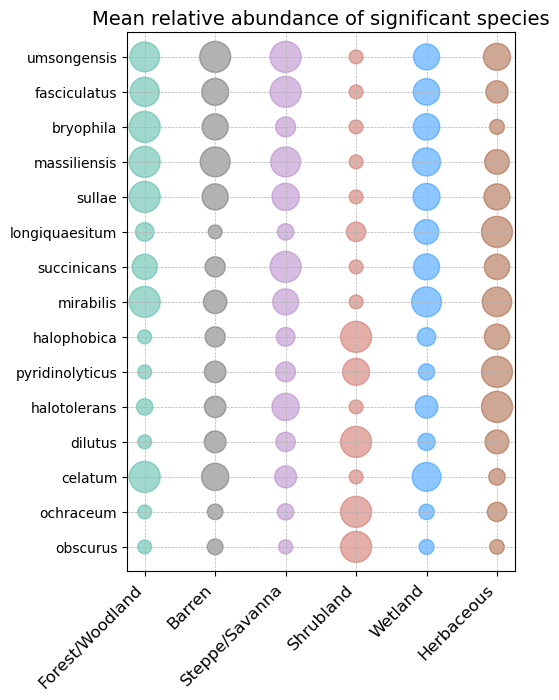

In [22]:
bubble_plot(taxa_ecosys_df, sig_var, 'Mean relative abundance of significant species', 'sig_species_ecosystems.pdf')

# Note: Bubble sizes are normalized within each bacterial group.

### Family

In [23]:
data = data_cleaner(pd.read_csv("../../Input/family_count.csv"), "f__")
data.rename(columns={"index" : "Sample ID"}, inplace=True)

#merging with Ecosys data
taxa_ecosys_df = pd.merge(data, ecosystem_df, on='Sample ID')

#sig var
sig_var, pval = KW_test(taxa_ecosys_df)

/var/folders/5h/7h8l0j1s1mj4_v25_lxmx1lw0000gn/T/ipykernel_34653/4041562419.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      0.002682
1      0.007225
2      0.006096
3      0.008222
4      0.000000
         ...   
613    0.000000
614    0.002284
615    0.000000
616    0.005250
617    0.001878
Name: RB40, Length: 618, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  count_data_cleaned.iloc[:, 1:] = count_data_cleaned.iloc[:, 1:].div(row_sums, axis=0)
/var/folders/5h/7h8l0j1s1mj4_v25_lxmx1lw0000gn/T/ipykernel_34653/4041562419.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      0.004125
1      0.006400
2      0.010161
3      0.028444
4      0.000000
         ...   
613    0.011836
614    0.011990
615    0.008584
616    0.015000
617    0.000000
Name: mb2424, Length: 618, dty

Number of siginificant variables:  98
--------------------------------------------
RB40: 2.383168628137863e-07
mb2424: 3.8613657159644674e-10
Acidobacteriaceae: 1.1729947920068084e-17
Koribacteraceae: 1.70404117043841e-24
Solibacteraceae: 7.808548791999865e-08
Ellin6075: 1.1480250045897026e-05
AKIW874: 5.696598325973142e-13
C111: 0.0004666519438224037
EB1017: 1.25423342181834e-09
Iamiaceae: 5.943511829601295e-06
Actinosynnemataceae: 2.871358668660767e-11
Cellulomonadaceae: 6.174976216557229e-07
Cryptosporangiaceae: 2.4875311148180922e-14
Frankiaceae: 0.00016666283337118617
Geodermatophilaceae: 9.225776314319017e-30
Intrasporangiaceae: 6.620616684527218e-12
Kineosporiaceae: 6.54527417075182e-16
Microbacteriaceae: 4.380218144443675e-08
Micrococcaceae: 1.1916069728003527e-05
Micromonosporaceae: 1.002909103190385e-18
Mycobacteriaceae: 1.1002421996154967e-32
Nakamurellaceae: 8.14052638927167e-06
Nocardioidaceae: 8.035260167721332e-06
Promicromonosporaceae: 0.006072041769124396
Pseudonocardi

In [24]:
mean_df, mode_df, median_df, max_df, min_df = save_stats_to_csvs(taxa_ecosys_df, sig_var, pval, "sig_family_ecosystem")

#### OTU

In [25]:
otu_data = pd.read_csv("../../Input/OTU_rarify_relabun.csv", index_col=0)

otu_data_transposed = otu_data.transpose()
otu_data_transposed.reset_index(inplace=True)
otu_data_transposed.rename(columns={"index" : "Sample ID"}, inplace=True)

In [26]:
#merging with Ecosys data
otu_ecosys_df = pd.merge(otu_data_transposed, ecosystem_df, on='Sample ID')

#sig var
sig_var, pval = KW_test(otu_ecosys_df)

Number of siginificant variables:  447
--------------------------------------------
OTU_2: 0.0022808644841379147
OTU_7: 3.0695890076995975e-07
OTU_17: 0.0030766142013115426
OTU_26: 0.0004343092144176165
OTU_33: 0.0024788079152123577
OTU_43: 2.4721327743342764e-07
OTU_50: 1.7786360249514005e-19
OTU_53: 8.864632211209235e-07
OTU_63: 1.1133246006731526e-06
OTU_86: 1.4518883767709346e-05
OTU_98: 0.0004246417254154213
OTU_100: 4.681039819739551e-08
OTU_109: 0.00045531895393830467
OTU_112: 1.2439267852698584e-18
OTU_115: 0.0004343092144176165
OTU_120: 8.858135428495571e-12
OTU_142: 2.9997451134885034e-26
OTU_160: 2.673497601927091e-07
OTU_171: 0.000305945177398614
OTU_175: 2.8669988608415375e-15
OTU_177: 0.0004227029175829253
OTU_178: 0.010924508752049259
OTU_180: 6.33696978164848e-05
OTU_181: 8.767515250607898e-05
OTU_183: 0.00735228333600433
OTU_184: 4.79403344143379e-05
OTU_187: 9.49472851901579e-28
OTU_224: 0.0007246378284721337
OTU_228: 0.007920195314399855
OTU_237: 1.0837465893287048e-

In [27]:
mean_df, mode_df, median_df, max_df, min_df = save_stats_to_csvs(otu_ecosys_df, sig_var, pval, "sig_OTUs_ecosystem")